<a href="https://colab.research.google.com/github/masuareb/investigacion/blob/master/Aprendizaje_M%C3%A1quina_Tarea_02.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Temas Selectos de Aprendizaje Máquina
## Dr. Mariano Rivera Meraz
----------------
## Manuel Arturo Suárez Améndola
### Tarea 02
### Detección de neumonías a partir de imágenes de rayos X

### Importación de librerías, modelos base y definición de datos del problema

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications import EfficientNetB3

#### Cargamos datos de rayos X

##### Importamos datos desde Google Drive

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


Definimos directorios de datos

In [ ]:
import os

base_dir = 'gdrive/MyDrive/DeepLearning/Chest_xray'
train_dir      = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')
test_dir       = os.path.join(base_dir, 'test')         
checkpoint_dir = os.path.join(base_dir, 'checkpoints')
results_dir    = os.path.join(base_dir, 'results')

##### Definición de generadores de datos

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
# Generador para el conjunto de entrenamiento
# Con aumentación de datos
train_datagen = ImageDataGenerator(rescale           = 1./255,
                                   rotation_range    = 40,
                                   width_shift_range = 0.2,
                                   height_shift_range= 0.2,
                                   shear_range       = 0.2,
                                   zoom_range        = 0.2,
                                   horizontal_flip   = True,
                                   fill_mode         = 'constant',
                                   cval              = 0)

# Generador para el conjunto de validación y pruebas
# Sin aumentación de datos
test_datagen = ImageDataGenerator(rescale=1./255)

# Usamos flujos direccionados desde directorio
train_generator = train_datagen.flow_from_directory(
                        train_dir,                # directorio con datos de entrenamiento
                        target_size= (150, 150),  # tamaño de la imágenes 
                        batch_size = 5,   
                        shuffle    = True,
                        class_mode = 'binary')    # para clasificación binaria

validation_generator = test_datagen.flow_from_directory(
                        validation_dir,
                        target_size=(150, 150),
                        batch_size=5,
                        class_mode='binary')

test_generator = test_datagen.flow_from_directory(
        test_dir,
        target_size=(150, 150),
        batch_size=5,
        class_mode='binary')

Found 2000 images belonging to 2 classes.
Found 699 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


##### Número de epocas para el entrenamiento de todos los modelos

In [ ]:
num_epochs = 50

### Definición de funciones

##### Compilación y entrenamiento de la red

In [ ]:
from tensorflow.keras import optimizers
import time

def compile_and_train(model, name_model, checkpoint_subdir, epochs):
  model.compile(loss='binary_crossentropy',
                optimizer=optimizers.Nadam(learning_rate=2e-5),
                metrics=['acc'])

  # Definimos callback para almacenamiento de resultados de entrenamiento
  model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
      filepath=os.path.join(checkpoint_dir,checkpoint_subdir,'model-'+name_model+f'-epochs{epochs}'+'.hdf5'),
      monitor='val_accuracy',
      mode='max',
      # Se especifica almacenamiento por cada época
      save_freq='epoch')

  tstart = time.time()
  # Entrenamiento de la red
  result = model.fit(train_generator,
                      callbacks=[model_checkpoint_callback],
                      steps_per_epoch = 100, 
                      epochs          = epochs,
                      validation_data = validation_generator,
                      validation_steps= 50)

  # Tiempo de entrenamiento transcurrido
  print('Tiempo de entrenamiento: ', time.time()-tstart)

  return result 

##### Visualización de métricas

In [ ]:
import matplotlib.pyplot as plt

def visualize_metrics(fit_result):
  acc      = fit_result.history['acc']
  val_acc  = fit_result.history['val_acc']
  loss     = fit_result.history['loss']
  val_loss = fit_result.history['val_loss']

  epochs = range(len(acc))

  plt.plot(epochs, acc, 'bo', label='Entrenamiento acc')
  plt.plot(epochs, val_acc, 'b', label='Validación acc')
  plt.title('Accuracy - exactitud de entrenamiento y validación')
  plt.legend()

  plt.figure()

  plt.plot(epochs, loss, 'bo', label='Entrenamiento loss')
  plt.plot(epochs, val_loss, 'b', label='Validación loss')
  plt.title('Loss - función objetivo en entrenamiento y prueba')
  plt.legend()

  plt.show()

##### Almacenamiento de resultados de entrenamiento

In [ ]:
import os
import pickle
def save_results(results, results_dir, model_name, model_results, epochs):
  with open(os.path.join(results_dir,model_name+f'-{model_results}'+f'-epochs{epochs}'), 'wb') as file_pi:
    pickle.dump(results.history, file_pi)

##### Carga de resultados de entrenamiento

In [ ]:
def load_results(results_dir, model_name, model_results, epochs):
  with open(os.path.join(results_dir,model_name+f'-{model_results}'+f'-epochs{epochs}'), 'rb') as file_pi:
    return pickle.load(file_pi)

##### Evaluación del modelo

In [ ]:
def evaluate_model(model):  
  test_loss, test_acc = model.evaluate(test_generator, steps=50)
  print(f'Test accuracy: {test_acc}, Test loss: {test_loss}')
  return (test_loss, test_acc)

### Entrenamiento basado en ResNet50

#### Utilizamos ResNet50 sin la capa densa

In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import ResNet50

model_name = 'resnet50'
model_base = ResNet50(weights='imagenet',
                  include_top=False,
                  input_shape=(150, 150, 3))
model_base.summary()

renest50_trainable_layers = '''conv5_block1_1_conv
conv5_block1_1_bn
conv5_block1_2_conv
conv5_block1_2_bn
conv5_block1_0_conv
conv5_block1_3_conv
conv5_block1_0_bn
conv5_block1_3_bn
conv5_block2_1_conv
conv5_block2_1_bn
conv5_block2_2_conv
conv5_block2_2_bn
conv5_block2_3_conv
conv5_block2_3_bn
conv5_block3_1_conv
conv5_block3_1_bn
conv5_block3_2_conv
conv5_block3_2_bn
conv5_block3_3_conv
conv5_block3_3_bn'''.split('\n')

trainable_layers = renest50_trainable_layers

94781440/94765736 [==============================] - 0s 0us/step
Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 150, 150, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 156, 156, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 75, 75, 64)   9472        ['conv1_pad[0][0]']              
                                                                                                  
 conv1_bn (BatchNormalizat

#### Primer entrenamiento.- fijamos backbone y entrenamos últimas capas (densas)

##### Definición del modelo

In [ ]:
from tensorflow.keras import models
from tensorflow.keras import layers

rsnet50_model = models.Sequential()
# Agregamos el modelo cargado previamente como la capa base (backbone)
rsnet50_model.add(model_base)        
# Agregamos al modelo las capas densas para realizar el entrenamiento
rsnet50_model.add(layers.Flatten())
rsnet50_model.add(layers.Dense(256, activation='relu'))
rsnet50_model.add(layers.Dense(1, activation='sigmoid'))
rsnet50_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 5, 5, 2048)        23587712  
                                                                 
 flatten (Flatten)           (None, 51200)             0         
                                                                 
 dense (Dense)               (None, 256)               13107456  
                                                                 
 dense_1 (Dense)             (None, 1)                 257       
                                                                 
Total params: 36,695,425
Trainable params: 36,642,305
Non-trainable params: 53,120
_________________________________________________________________


##### Configuración de parámetros, fijamos backbone (definimos como no entrenable los parámetros de la capa base)

In [ ]:
rsnet50_model.layers[0].trainable = False
rsnet50_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 5, 5, 2048)        23587712  
                                                                 
 flatten (Flatten)           (None, 51200)             0         
                                                                 
 dense (Dense)               (None, 256)               13107456  
                                                                 
 dense_1 (Dense)             (None, 1)                 257       
                                                                 
Total params: 36,695,425
Trainable params: 13,107,713
Non-trainable params: 23,587,712
_________________________________________________________________


##### Compilación y entrenamiento

In [ ]:
rsnet50_dense_result = compile_and_train(rsnet50_model, model_name, 'dense-training', num_epochs)

Epoch 1/30
100/100 [==============================] - 163s 1s/step - loss: 0.6908 - acc: 0.5740 - val_loss: 0.6388 - val_acc: 0.8120
Epoch 2/30
100/100 [==============================] - 105s 1s/step - loss: 0.6541 - acc: 0.6360 - val_loss: 0.6307 - val_acc: 0.5640
Epoch 3/30
100/100 [==============================] - 72s 728ms/step - loss: 0.6112 - acc: 0.6600 - val_loss: 0.5928 - val_acc: 0.7360
Epoch 4/30
100/100 [==============================] - 59s 595ms/step - loss: 0.5903 - acc: 0.6980 - val_loss: 0.5728 - val_acc: 0.6720
Epoch 5/30
100/100 [==============================] - 47s 467ms/step - loss: 0.5691 - acc: 0.7100 - val_loss: 0.5388 - val_acc: 0.7560
Epoch 6/30
100/100 [==============================] - 43s 426ms/step - loss: 0.5797 - acc: 0.7020 - val_loss: 0.5638 - val_acc: 0.6520
Epoch 7/30
100/100 [==============================] - 40s 403ms/step - loss: 0.5683 - acc: 0.7200 - val_loss: 0.5409 - val_acc: 0.7320
Epoch 8/30
100/100 [==============================] - 34s 3

In [ ]:
save_results(rsnet50_dense_result, results_dir, model_name, 'dense_results', num_epochs)

##### Visualizamos métricas de evaluación y desempeño

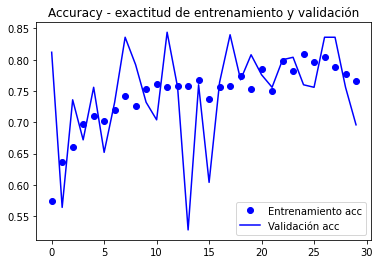

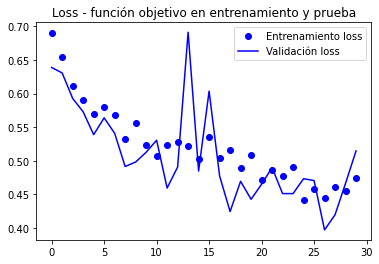

In [ ]:
visualize_metrics(rsnet50_dense_result)

##### Evaluamos

In [ ]:
evaluate_model(rsnet50_model)

50/50 [==============================] - 61s 1s/step - loss: 0.5298 - acc: 0.7120
Test accuracy: 0.7120000123977661, Test loss: 0.5297926664352417


#### Segundo entrenamiento (*fine-tuning* ).- descongelamos últimas capas convolucionales.

##### Especificamos últimas capas del modelo base como entrenables

In [ ]:
# Cargamos modelo previamente entrenado
rsnet50_model = keras.models.load_model(os.path.join(checkpoint_dir,'dense-training','model-'+model_name+f'-epochs{num_epochs}'+'.hdf5'))
# Configuramos capas entrenables
rsnet50_model.layers[0].trainable = True

set_trainable = False
for layer in rsnet50_model.layers[0].layers:
    if layer.name in trainable_layers:
        layer.trainable = True
    else:
        layer.trainable = False
rsnet50_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 5, 5, 2048)        23587712  
                                                                 
 flatten (Flatten)           (None, 51200)             0         
                                                                 
 dense (Dense)               (None, 256)               13107456  
                                                                 
 dense_1 (Dense)             (None, 1)                 257       
                                                                 
Total params: 36,695,425
Trainable params: 28,083,713
Non-trainable params: 8,611,712
_________________________________________________________________


##### Fijamos número de épocas y entrenamos

In [ ]:
rsnet50_fine_result = compile_and_train(rsnet50_model, model_name, 'fine-tuning', num_epochs)

Epoch 1/30
100/100 [==============================] - 32s 238ms/step - loss: 0.8290 - acc: 0.6460 - val_loss: 0.9167 - val_acc: 0.4840
Epoch 2/30
100/100 [==============================] - 25s 249ms/step - loss: 0.5826 - acc: 0.6980 - val_loss: 0.5404 - val_acc: 0.8120
Epoch 3/30
100/100 [==============================] - 24s 241ms/step - loss: 0.5775 - acc: 0.7160 - val_loss: 0.5084 - val_acc: 0.6920
Epoch 4/30
100/100 [==============================] - 26s 256ms/step - loss: 0.5170 - acc: 0.7500 - val_loss: 0.3856 - val_acc: 0.8480
Epoch 5/30
100/100 [==============================] - 25s 251ms/step - loss: 0.4894 - acc: 0.7580 - val_loss: 0.2991 - val_acc: 0.8640
Epoch 6/30
100/100 [==============================] - 24s 242ms/step - loss: 0.5279 - acc: 0.7540 - val_loss: 0.3364 - val_acc: 0.8640
Epoch 7/30
100/100 [==============================] - 25s 250ms/step - loss: 0.5232 - acc: 0.7620 - val_loss: 0.4021 - val_acc: 0.8520
Epoch 8/30
100/100 [==============================] - 2

In [ ]:
save_results(rsnet50_fine_result, results_dir, model_name, 'fine_results', num_epochs)

##### Visualizamos métricas

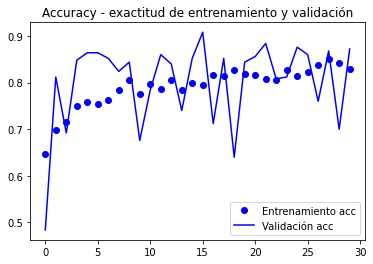

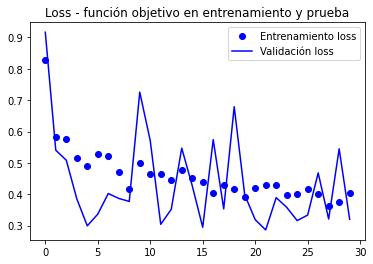

In [ ]:
visualize_metrics(rsnet50_fine_result)

##### Evaluamos

In [ ]:
evaluate_model(rsnet50_model)

50/50 [==============================] - 35s 711ms/step - loss: 0.3348 - acc: 0.8720
Test accuracy: 0.871999979019165, Test loss: 0.33475160598754883


#### Tercer entrenamiento (Full-tunning).- descongelamos toda la capa base y entrenamos

##### Configuramos parámetros de entrenamiento

In [ ]:
# Cargamos modelo previamente entrenado
rsnet50_model = keras.models.load_model(os.path.join(checkpoint_dir,'fine-tuning','model-'+model_name+f'-epochs{num_epochs}'+'.hdf5'))
# Configuramos capas entrenables
rsnet50_model.layers[0].trainable = True
rsnet50_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 5, 5, 2048)        23587712  
                                                                 
 flatten (Flatten)           (None, 51200)             0         
                                                                 
 dense (Dense)               (None, 256)               13107456  
                                                                 
 dense_1 (Dense)             (None, 1)                 257       
                                                                 
Total params: 36,695,425
Trainable params: 36,642,305
Non-trainable params: 53,120
_________________________________________________________________


##### Compilamos y entrenamos

In [ ]:
rsnet50_full_result = compile_and_train(rsnet50_model, model_name, 'full-tuning', num_epochs)

Epoch 1/30
100/100 [==============================] - 603s 6s/step - loss: 0.4923 - acc: 0.8100 - val_loss: 0.6534 - val_acc: 0.5800
Epoch 2/30
100/100 [==============================] - 409s 4s/step - loss: 0.3420 - acc: 0.8740 - val_loss: 0.6219 - val_acc: 0.6640
Epoch 3/30
100/100 [==============================] - 294s 3s/step - loss: 0.2491 - acc: 0.9060 - val_loss: 0.7126 - val_acc: 0.5440
Epoch 4/30
100/100 [==============================] - 231s 2s/step - loss: 0.2061 - acc: 0.9220 - val_loss: 0.9651 - val_acc: 0.3960
Epoch 5/30
100/100 [==============================] - 167s 2s/step - loss: 0.2810 - acc: 0.8860 - val_loss: 2.0446 - val_acc: 0.5040
Epoch 6/30
100/100 [==============================] - 125s 1s/step - loss: 0.1936 - acc: 0.9240 - val_loss: 3.0037 - val_acc: 0.4760
Epoch 7/30
100/100 [==============================] - 102s 1s/step - loss: 0.2070 - acc: 0.9300 - val_loss: 2.7934 - val_acc: 0.4880
Epoch 8/30
100/100 [==============================] - 83s 836ms/step 

In [ ]:
save_results(rsnet50_full_result, results_dir, model_name, 'full_results', num_epochs)

##### Visualizamos métricas

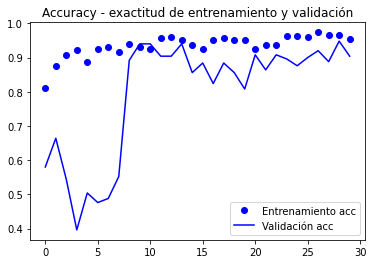

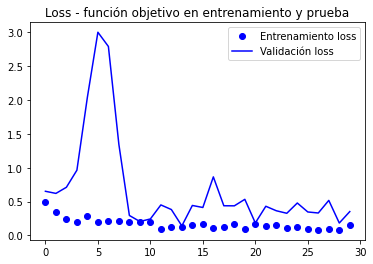

In [ ]:
visualize_metrics(rsnet50_full_result)

##### Evaluamos

In [ ]:
evaluate_model(rsnet50_model)

50/50 [==============================] - 190s 4s/step - loss: 0.2695 - acc: 0.9200
Test accuracy: 0.9200000166893005, Test loss: 0.2695094645023346


#### Comparación de resultados para modelo ResNet50

##### Cargamos resultados almacenados

In [ ]:
rsnet50_dense_history = load_results(results_dir, model_name, 'dense_results', num_epochs)
rsnet50_fine_history = load_results(results_dir, model_name, 'fine_results', num_epochs)
rsnet50_full_history = load_results(results_dir, model_name, 'full_results', num_epochs)

##### Graficamos resultados comparativos

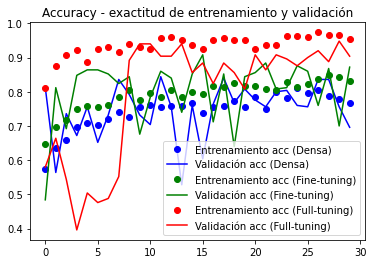

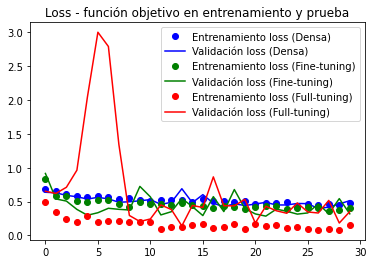

In [ ]:
rsnet50_dense_acc      = rsnet50_dense_history['acc']
rsnet50_dense_val_acc  = rsnet50_dense_history['val_acc']
rsnet50_dense_loss     = rsnet50_dense_history['loss']
rsnet50_dense_val_loss = rsnet50_dense_history['val_loss']
# -----------------------------------------------
rsnet50_fine_acc      = rsnet50_fine_history['acc']
rsnet50_fine_val_acc  = rsnet50_fine_history['val_acc']
rsnet50_fine_loss     = rsnet50_fine_history['loss']
rsnet50_fine_val_loss = rsnet50_fine_history['val_loss']
#----------------------------------------------
rsnet50_full_acc      = rsnet50_full_history['acc']
rsnet50_full_val_acc  = rsnet50_full_history['val_acc']
rsnet50_full_loss     = rsnet50_full_history['loss']
rsnet50_full_val_loss = rsnet50_full_history['val_loss']

epochs = range(len(rsnet50_dense_acc))

plt.plot(epochs, rsnet50_dense_acc, 'bo', label='Entrenamiento acc (Densa)')
plt.plot(epochs, rsnet50_dense_val_acc, 'b', label='Validación acc (Densa)')
plt.plot(epochs, rsnet50_fine_acc, 'go', label='Entrenamiento acc (Fine-tuning)')
plt.plot(epochs, rsnet50_fine_val_acc, 'g', label='Validación acc (Fine-tuning)')
plt.plot(epochs, rsnet50_full_acc, 'ro', label='Entrenamiento acc (Full-tuning)')
plt.plot(epochs, rsnet50_full_val_acc, 'r', label='Validación acc (Full-tuning)')
plt.title('Accuracy - exactitud de entrenamiento y validación')
plt.legend()

plt.figure()

plt.plot(epochs, rsnet50_dense_loss, 'bo', label='Entrenamiento loss (Densa)')
plt.plot(epochs, rsnet50_dense_val_loss, 'b', label='Validación loss (Densa)')
plt.plot(epochs, rsnet50_fine_loss, 'go', label='Entrenamiento loss (Fine-tuning)')
plt.plot(epochs, rsnet50_fine_val_loss, 'g', label='Validación loss (Fine-tuning)')
plt.plot(epochs, rsnet50_full_loss, 'ro', label='Entrenamiento loss (Full-tuning)')
plt.plot(epochs, rsnet50_full_val_loss, 'r', label='Validación loss (Full-tuning)')
plt.title('Loss - función objetivo en entrenamiento y prueba')
plt.legend()

plt.show()

### Entrenamiento basado en EfficientNetB3

#### Utilizamos EfficientNetB3 sin la capa densa

In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import EfficientNetB3

model_name = 'efficientnetb3'
model_base = EfficientNetB3(weights='imagenet',
                  include_top=False,
                  input_shape=(150, 150, 3))
model_base.summary()

efficientnetb3_trainable_layers = '''block7a_expand_conv
 block7a_expand_bn
 block7a_dwconv
 block7a_bn
 block7a_se_reduce
 block7a_se_expand
 block7a_project_conv
 block7a_project_bn
 block7b_expand_conv
 block7b_expand_bn
 block7b_expand_activation                                                                        
 block7b_dwconv
 block7b_bn
 block7b_se_reduce
 block7b_se_expand
 block7b_project_conv
 block7b_project_bn
 top_conv
 top_bn'''.split('\n')

trainable_layers = efficientnetb3_trainable_layers

43950080/43941136 [==============================] - 1s 0us/step
Model: "efficientnetb3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 150, 150, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling (Rescaling)          (None, 150, 150, 3)  0           ['input_2[0][0]']                
                                                                                                  
 normalization (Normalization)  (None, 150, 150, 3)  7           ['rescaling[0][0]']              
                                                                                                  
 stem_conv_pad (Zero

#### Primer entrenamiento.- fijamos backbone y entrenamos últimas capas (densas)

##### Definición del modelo

In [ ]:
from tensorflow.keras import models
from tensorflow.keras import layers

effnetb3_model = models.Sequential()
# Agregamos el modelo cargado previamente como la capa base (backbone)
effnetb3_model.add(model_base)        
# Agregamos al modelo las capas densas para realizar el entrenamiento
effnetb3_model.add(layers.Flatten())
effnetb3_model.add(layers.Dense(256, activation='relu'))
effnetb3_model.add(layers.Dense(1, activation='sigmoid'))
effnetb3_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb3 (Functional)  (None, 5, 5, 1536)       10783535  
                                                                 
 flatten (Flatten)           (None, 38400)             0         
                                                                 
 dense (Dense)               (None, 256)               9830656   
                                                                 
 dense_1 (Dense)             (None, 1)                 257       
                                                                 
Total params: 20,614,448
Trainable params: 20,527,145
Non-trainable params: 87,303
_________________________________________________________________


##### Configuración de parámetros, fijamos backbone (definimos como no entrenable los parámetros de la capa base)

In [ ]:
effnetb3_model.layers[0].trainable = False
effnetb3_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb3 (Functional)  (None, 5, 5, 1536)       10783535  
                                                                 
 flatten (Flatten)           (None, 38400)             0         
                                                                 
 dense (Dense)               (None, 256)               9830656   
                                                                 
 dense_1 (Dense)             (None, 1)                 257       
                                                                 
Total params: 20,614,448
Trainable params: 9,830,913
Non-trainable params: 10,783,535
_________________________________________________________________


##### Compilación y entrenamiento

In [ ]:
effnetb3_dense_result = compile_and_train(effnetb3_model, model_name, 'dense-training', num_epochs)

Epoch 1/30
100/100 [==============================] - 28s 189ms/step - loss: 0.7777 - acc: 0.5060 - val_loss: 0.8421 - val_acc: 0.4520
Epoch 2/30
100/100 [==============================] - 19s 192ms/step - loss: 0.7479 - acc: 0.5220 - val_loss: 0.8423 - val_acc: 0.5200
Epoch 3/30
100/100 [==============================] - 19s 186ms/step - loss: 0.7496 - acc: 0.5300 - val_loss: 0.7471 - val_acc: 0.5200
Epoch 4/30
100/100 [==============================] - 19s 189ms/step - loss: 0.7376 - acc: 0.5140 - val_loss: 0.7081 - val_acc: 0.5120
Epoch 5/30
100/100 [==============================] - 18s 182ms/step - loss: 0.7355 - acc: 0.4880 - val_loss: 0.7043 - val_acc: 0.5040
Epoch 6/30
100/100 [==============================] - 19s 187ms/step - loss: 0.7407 - acc: 0.4980 - val_loss: 0.7051 - val_acc: 0.4600
Epoch 7/30
100/100 [==============================] - 19s 186ms/step - loss: 0.7484 - acc: 0.4740 - val_loss: 0.6926 - val_acc: 0.5400
Epoch 8/30
100/100 [==============================] - 1

In [ ]:
save_results(effnetb3_dense_result, results_dir, model_name, 'dense_results', num_epochs)

##### Visualizamos métricas de evaluación y desempeño

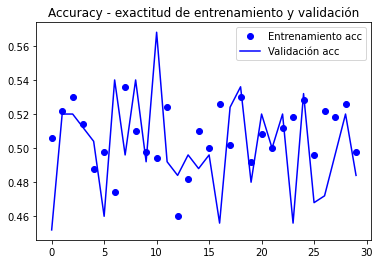

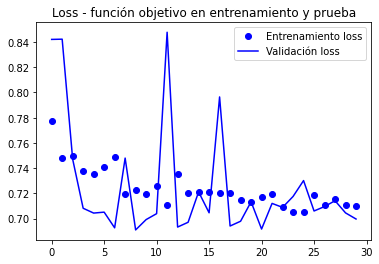

In [ ]:
visualize_metrics(effnetb3_dense_result)

##### Evaluamos

In [ ]:
evaluate_model(effnetb3_model)

50/50 [==============================] - 108s 2s/step - loss: 0.6712 - acc: 0.6400
Test accuracy: 0.6399999856948853, Test loss: 0.6712003946304321


#### Segundo entrenamiento (*fine-tuning* ).- descongelamos últimas capas convolucionales.

##### Especificamos últimas capas del modelo base como entrenables

In [ ]:
from tensorflow import keras
# Cargamos modelo previamente entrenado
effnetb3_model = keras.models.load_model(os.path.join(checkpoint_dir,'dense-training','model-'+model_name+f'-epochs{num_epochs}'+'.hdf5'))
# Configuramos capas entrenables
effnetb3_model.layers[0].trainable = True

set_trainable = False
for layer in effnetb3_model.layers[0].layers:
    if layer.name in trainable_layers:
        layer.trainable = True
    else:
        layer.trainable = False
effnetb3_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb3 (Functional)  (None, 5, 5, 1536)       10783535  
                                                                 
 flatten (Flatten)           (None, 38400)             0         
                                                                 
 dense (Dense)               (None, 256)               9830656   
                                                                 
 dense_1 (Dense)             (None, 1)                 257       
                                                                 
Total params: 20,614,448
Trainable params: 10,153,857
Non-trainable params: 10,460,591
_________________________________________________________________


##### Fijamos número de épocas y entrenamos

In [ ]:
effnetb3_fine_result = compile_and_train(effnetb3_model, model_name, 'fine-tuning', num_epochs)

Epoch 1/30
100/100 [==============================] - 27s 185ms/step - loss: 0.7165 - acc: 0.5060 - val_loss: 0.6960 - val_acc: 0.5080
Epoch 2/30
100/100 [==============================] - 18s 182ms/step - loss: 0.7163 - acc: 0.5100 - val_loss: 0.7006 - val_acc: 0.5000
Epoch 3/30
100/100 [==============================] - 19s 188ms/step - loss: 0.7071 - acc: 0.5200 - val_loss: 0.7014 - val_acc: 0.5000
Epoch 4/30
100/100 [==============================] - 19s 190ms/step - loss: 0.7138 - acc: 0.4800 - val_loss: 0.6989 - val_acc: 0.5160
Epoch 5/30
100/100 [==============================] - 19s 188ms/step - loss: 0.7160 - acc: 0.4900 - val_loss: 0.6980 - val_acc: 0.4440
Epoch 6/30
100/100 [==============================] - 18s 183ms/step - loss: 0.7071 - acc: 0.5100 - val_loss: 0.6888 - val_acc: 0.5440
Epoch 7/30
100/100 [==============================] - 19s 190ms/step - loss: 0.7061 - acc: 0.5400 - val_loss: 0.8251 - val_acc: 0.4680
Epoch 8/30
100/100 [==============================] - 1

In [ ]:
save_results(effnetb3_fine_result, results_dir, model_name, 'fine_results', num_epochs)

##### Visualizamos métricas

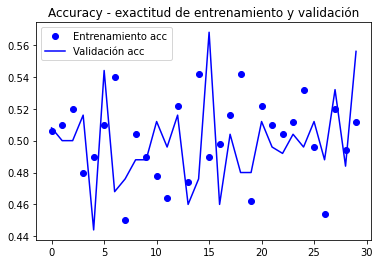

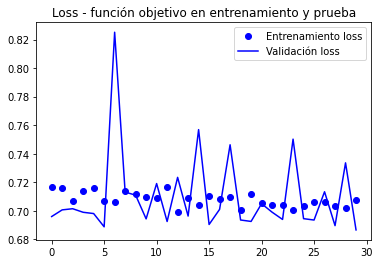

In [ ]:
visualize_metrics(effnetb3_fine_result)

##### Evaluamos

In [ ]:
evaluate_model(effnetb3_model)

50/50 [==============================] - 68s 1s/step - loss: 0.6778 - acc: 0.6200
Test accuracy: 0.6200000047683716, Test loss: 0.6778134107589722


#### Tercer entrenamiento (Full-tunning).- descongelamos toda la capa base y entrenamos

##### Configuramos parámetros de entrenamiento

In [ ]:
# Cargamos modelo previamente entrenado
effnetb3_model = keras.models.load_model(os.path.join(checkpoint_dir,'fine-tuning','model-'+model_name+f'-epochs{num_epochs}'+'.hdf5'))
# Configuramos capas entrenables
effnetb3_model.layers[0].trainable = True
effnetb3_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb3 (Functional)  (None, 5, 5, 1536)       10783535  
                                                                 
 flatten (Flatten)           (None, 38400)             0         
                                                                 
 dense (Dense)               (None, 256)               9830656   
                                                                 
 dense_1 (Dense)             (None, 1)                 257       
                                                                 
Total params: 20,614,448
Trainable params: 20,527,145
Non-trainable params: 87,303
_________________________________________________________________


##### Compilamos y entrenamos

In [ ]:
effnetb3_full_result = compile_and_train(effnetb3_model, model_name, 'full-tuning', num_epochs)

Epoch 1/30
100/100 [==============================] - 55s 245ms/step - loss: 0.5102 - acc: 0.7360 - val_loss: 0.7602 - val_acc: 0.4680
Epoch 2/30
100/100 [==============================] - 25s 248ms/step - loss: 0.3512 - acc: 0.8600 - val_loss: 0.7641 - val_acc: 0.4800
Epoch 3/30
100/100 [==============================] - 24s 240ms/step - loss: 0.3456 - acc: 0.8580 - val_loss: 1.1704 - val_acc: 0.5240
Epoch 4/30
100/100 [==============================] - 23s 234ms/step - loss: 0.4084 - acc: 0.8440 - val_loss: 1.0465 - val_acc: 0.4840
Epoch 5/30
100/100 [==============================] - 24s 242ms/step - loss: 0.3035 - acc: 0.8840 - val_loss: 1.0775 - val_acc: 0.4600
Epoch 6/30
100/100 [==============================] - 24s 243ms/step - loss: 0.2996 - acc: 0.8600 - val_loss: 0.8466 - val_acc: 0.5320
Epoch 7/30
100/100 [==============================] - 23s 231ms/step - loss: 0.3239 - acc: 0.8960 - val_loss: 0.5084 - val_acc: 0.7320
Epoch 8/30
100/100 [==============================] - 2

In [ ]:
save_results(effnetb3_full_result, results_dir, model_name, 'full_results', num_epochs)

##### Visualizamos métricas

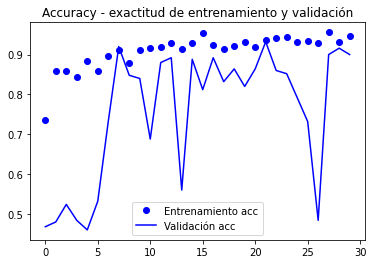

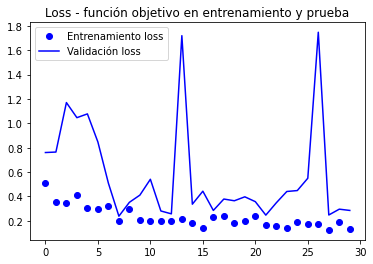

In [ ]:
visualize_metrics(effnetb3_full_result)

##### Evaluamos

In [ ]:
evaluate_model(effnetb3_model)

50/50 [==============================] - 39s 789ms/step - loss: 0.3991 - acc: 0.8480
Test accuracy: 0.8479999899864197, Test loss: 0.3990919589996338


#### Comparación de resultados para modelo EfficientNetB3

##### Cargamos resultados almacenados

In [ ]:
effnetb3_dense_history = load_results(results_dir, model_name, 'dense_results', num_epochs)
effnetb3_fine_history = load_results(results_dir, model_name, 'fine_results', num_epochs)
effnetb3_full_history = load_results(results_dir, model_name, 'full_results', num_epochs)

##### Graficamos resultados comparativos

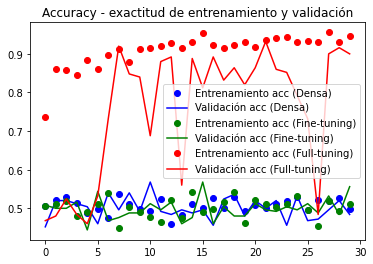

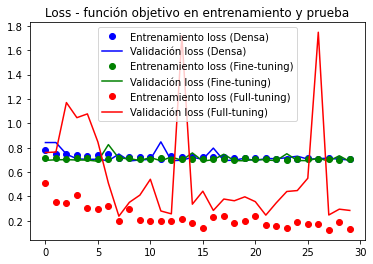

In [ ]:
effnetb3_dense_acc      = effnetb3_dense_history['acc']
effnetb3_dense_val_acc  = effnetb3_dense_history['val_acc']
effnetb3_dense_loss     = effnetb3_dense_history['loss']
effnetb3_dense_val_loss = effnetb3_dense_history['val_loss']
# -----------------------------------------------
effnetb3_fine_acc      = effnetb3_fine_history['acc']
effnetb3_fine_val_acc  = effnetb3_fine_history['val_acc']
effnetb3_fine_loss     = effnetb3_fine_history['loss']
effnetb3_fine_val_loss = effnetb3_fine_history['val_loss']
#----------------------------------------------
effnetb3_full_acc      = effnetb3_full_history['acc']
effnetb3_full_val_acc  = effnetb3_full_history['val_acc']
effnetb3_full_loss     = effnetb3_full_history['loss']
effnetb3_full_val_loss = effnetb3_full_history['val_loss']

epochs = range(len(effnetb3_dense_acc))

plt.plot(epochs, effnetb3_dense_acc, 'bo', label='Entrenamiento acc (Densa)')
plt.plot(epochs, effnetb3_dense_val_acc, 'b', label='Validación acc (Densa)')
plt.plot(epochs, effnetb3_fine_acc, 'go', label='Entrenamiento acc (Fine-tuning)')
plt.plot(epochs, effnetb3_fine_val_acc, 'g', label='Validación acc (Fine-tuning)')
plt.plot(epochs, effnetb3_full_acc, 'ro', label='Entrenamiento acc (Full-tuning)')
plt.plot(epochs, effnetb3_full_val_acc, 'r', label='Validación acc (Full-tuning)')
plt.title('Accuracy - exactitud de entrenamiento y validación')
plt.legend()

plt.figure()

plt.plot(epochs, effnetb3_dense_loss, 'bo', label='Entrenamiento loss (Densa)')
plt.plot(epochs, effnetb3_dense_val_loss, 'b', label='Validación loss (Densa)')
plt.plot(epochs, effnetb3_fine_loss, 'go', label='Entrenamiento loss (Fine-tuning)')
plt.plot(epochs, effnetb3_fine_val_loss, 'g', label='Validación loss (Fine-tuning)')
plt.plot(epochs, effnetb3_full_loss, 'ro', label='Entrenamiento loss (Full-tuning)')
plt.plot(epochs, effnetb3_full_val_loss, 'r', label='Validación loss (Full-tuning)')
plt.title('Loss - función objetivo en entrenamiento y prueba')
plt.legend()

plt.show()

### Comparación de resultados entre modelos

#### Cargamos resultados de ambos modelos

In [ ]:
rsnet50_dense_history = load_results(results_dir, 'resnet50', 'dense_results', num_epochs)
rsnet50_fine_history = load_results(results_dir, 'resnet50', 'fine_results', num_epochs)
rsnet50_full_history = load_results(results_dir, 'resnet50', 'full_results', num_epochs)
effnetb3_dense_history = load_results(results_dir, 'efficientnetb3', 'dense_results', num_epochs)
effnetb3_fine_history = load_results(results_dir, 'efficientnetb3', 'fine_results', num_epochs)
effnetb3_full_history = load_results(results_dir, 'efficientnetb3', 'full_results', num_epochs)

In [ ]:
rsnet50_dense_acc      = rsnet50_dense_history['acc']
rsnet50_dense_val_acc  = rsnet50_dense_history['val_acc']
rsnet50_dense_loss     = rsnet50_dense_history['loss']
rsnet50_dense_val_loss = rsnet50_dense_history['val_loss']
# -----------------------------------------------
rsnet50_fine_acc      = rsnet50_fine_history['acc']
rsnet50_fine_val_acc  = rsnet50_fine_history['val_acc']
rsnet50_fine_loss     = rsnet50_fine_history['loss']
rsnet50_fine_val_loss = rsnet50_fine_history['val_loss']
#----------------------------------------------
rsnet50_full_acc      = rsnet50_full_history['acc']
rsnet50_full_val_acc  = rsnet50_full_history['val_acc']
rsnet50_full_loss     = rsnet50_full_history['loss']
rsnet50_full_val_loss = rsnet50_full_history['val_loss']
#----------------------------------------------
effnetb3_dense_acc      = effnetb3_dense_history['acc']
effnetb3_dense_val_acc  = effnetb3_dense_history['val_acc']
effnetb3_dense_loss     = effnetb3_dense_history['loss']
effnetb3_dense_val_loss = effnetb3_dense_history['val_loss']
# -----------------------------------------------
effnetb3_fine_acc      = effnetb3_fine_history['acc']
effnetb3_fine_val_acc  = effnetb3_fine_history['val_acc']
effnetb3_fine_loss     = effnetb3_fine_history['loss']
effnetb3_fine_val_loss = effnetb3_fine_history['val_loss']
#----------------------------------------------
effnetb3_full_acc      = effnetb3_full_history['acc']
effnetb3_full_val_acc  = effnetb3_full_history['val_acc']
effnetb3_full_loss     = effnetb3_full_history['loss']
effnetb3_full_val_loss = effnetb3_full_history['val_loss']


#### Resultados entrenamiento capa Densa

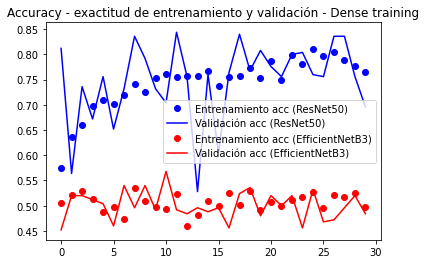

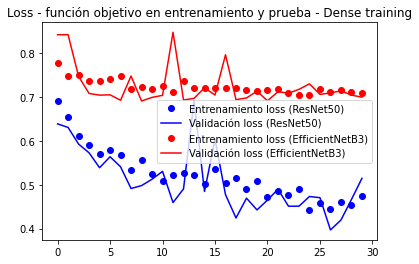

In [ ]:
plt.plot(epochs, rsnet50_dense_acc, 'bo', label='Entrenamiento acc (ResNet50)')
plt.plot(epochs, rsnet50_dense_val_acc, 'b', label='Validación acc (ResNet50)')
plt.plot(epochs, effnetb3_dense_acc, 'ro', label='Entrenamiento acc (EfficientNetB3)')
plt.plot(epochs, effnetb3_dense_val_acc, 'r', label='Validación acc (EfficientNetB3)')
plt.title('Accuracy - exactitud de entrenamiento y validación - Dense training')
plt.legend()

plt.figure()

plt.plot(epochs, rsnet50_dense_loss, 'bo', label='Entrenamiento loss (ResNet50)')
plt.plot(epochs, rsnet50_dense_val_loss, 'b', label='Validación loss (ResNet50)')
plt.plot(epochs, effnetb3_dense_loss, 'ro', label='Entrenamiento loss (EfficientNetB3)')
plt.plot(epochs, effnetb3_dense_val_loss, 'r', label='Validación loss (EfficientNetB3)')
plt.title('Loss - función objetivo en entrenamiento y prueba - Dense training')
plt.legend()

plt.show()

#### Resultados entrenamiento Fine-tuning

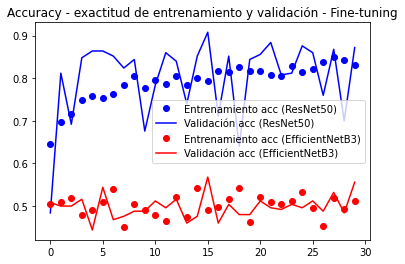

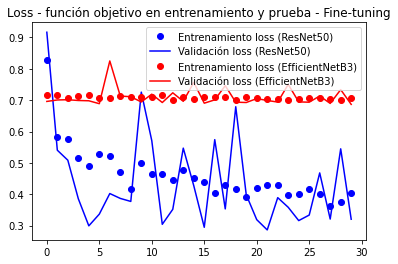

In [ ]:
plt.plot(epochs, rsnet50_fine_acc, 'bo', label='Entrenamiento acc (ResNet50)')
plt.plot(epochs, rsnet50_fine_val_acc, 'b', label='Validación acc (ResNet50)')
plt.plot(epochs, effnetb3_fine_acc, 'ro', label='Entrenamiento acc (EfficientNetB3)')
plt.plot(epochs, effnetb3_fine_val_acc, 'r', label='Validación acc (EfficientNetB3)')
plt.title('Accuracy - exactitud de entrenamiento y validación - Fine-tuning')
plt.legend()

plt.figure()
plt.plot(epochs, rsnet50_fine_loss, 'bo', label='Entrenamiento loss (ResNet50)')
plt.plot(epochs, rsnet50_fine_val_loss, 'b', label='Validación loss (ResNet50)')
plt.plot(epochs, effnetb3_fine_loss, 'ro', label='Entrenamiento loss (EfficientNetB3)')
plt.plot(epochs, effnetb3_fine_val_loss, 'r', label='Validación loss (EfficientNetB3)')
plt.title('Loss - función objetivo en entrenamiento y prueba - Fine-tuning')
plt.legend()

plt.show()

#### Resultados entrenamiento Full-tuning

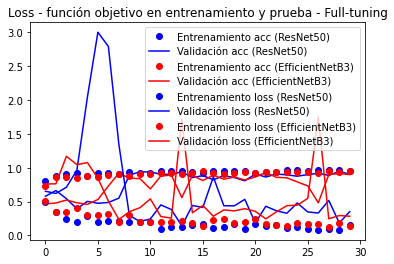

In [ ]:
plt.plot(epochs, rsnet50_full_acc, 'bo', label='Entrenamiento acc (ResNet50)')
plt.plot(epochs, rsnet50_full_val_acc, 'b', label='Validación acc (ResNet50)')
plt.plot(epochs, effnetb3_full_acc, 'ro', label='Entrenamiento acc (EfficientNetB3)')
plt.plot(epochs, effnetb3_full_val_acc, 'r', label='Validación acc (EfficientNetB3)')
plt.title('Accuracy - exactitud de entrenamiento y validación - Full-tuning')
plt.legend()
plt.plot(epochs, rsnet50_full_loss, 'bo', label='Entrenamiento loss (ResNet50)')
plt.plot(epochs, rsnet50_full_val_loss, 'b', label='Validación loss (ResNet50)')
plt.plot(epochs, effnetb3_full_loss, 'ro', label='Entrenamiento loss (EfficientNetB3)')
plt.plot(epochs, effnetb3_full_val_loss, 'r', label='Validación loss (EfficientNetB3)')
plt.title('Loss - función objetivo en entrenamiento y prueba - Full-tuning')
plt.legend()

plt.show()

#### Evaluación de modelos en el conjunto de prueba

In [ ]:
# Cargamos modelos previamente almacenados y evaluamos
rsnet50_model = keras.models.load_model(os.path.join(checkpoint_dir,'dense-training','model-'+'resnet50'+f'-epochs{num_epochs}'+'.hdf5'))
(rsnet50_dense_model_test_loss, rsnet50_dense_model_test_acc) = evaluate(rsnet50_model)
#--------------------------------------------------------------------------------------------------------------------------------------
rsnet50_model = keras.models.load_model(os.path.join(checkpoint_dir,'fine-tuning','model-'+'resnet50'+f'-epochs{num_epochs}'+'.hdf5'))
(rsnet50_fine_model_test_loss, rsnet50_fine_model_test_acc) = evaluate(rsnet50_model)
#--------------------------------------------------------------------------------------------------------------------------------------
rsnet50_model = keras.models.load_model(os.path.join(checkpoint_dir,'full-tuning','model-'+'resnet50'+f'-epochs{num_epochs}'+'.hdf5'))
(rsnet50_full_model_test_loss, rsnet50_full_model_test_acc) = evaluate(rsnet50_model)
#--------------------------------------------------------------------------------------------------------------------------------------
effnetb3_model = keras.models.load_model(os.path.join(checkpoint_dir,'dense-training','model-'+'efficientnetb3'+f'-epochs{num_epochs}'+'.hdf5'))
(effnetb3_dense_model_test_loss, effnetb3_dense_model_test_acc) = evaluate(effnetb3_model)
#--------------------------------------------------------------------------------------------------------------------------------------
effnetb3_model = keras.models.load_model(os.path.join(checkpoint_dir,'fine-tuning','model-'+'efficientnetb3'+f'-epochs{num_epochs}'+'.hdf5'))
(effnetb3_dense_model_test_loss, effnetb3_dense_model_test_acc) = evaluate(effnetb3_model)
#--------------------------------------------------------------------------------------------------------------------------------------
effnetb3_model = keras.models.load_model(os.path.join(checkpoint_dir,'full-tuning','model-'+'efficientnetb3'+f'-epochs{num_epochs}'+'.hdf5'))
(effnetb3_dense_model_test_loss, effnetb3_dense_model_test_acc) = evaluate(effnetb3_model)

In [ ]:
import matplotlib.pyplot as plt
import numpy as np


labels = ['RestNet50', 'EfficientNetB3']
men_means = [20, 34, 30, 35, 27]
women_means = [25, 32, 34, 20, 25]

x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, men_means, width, label='Men')
rects2 = ax.bar(x + width/2, women_means, width, label='Women')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Scores')
ax.set_title('Scores by group and gender')
ax.set_xticks(x, labels)
ax.legend()

ax.bar_label(rects1, padding=3)
ax.bar_label(rects2, padding=3)

fig.tight_layout()

plt.show()

### Conclusiones